In [1]:
import os
print(os.getcwd())
import sys
sys.path.append('/local/scratch/kchan76/sparse-coarse-operator/')
from libs.pde import *
from libs.rotated_laplacian import RotatedLaplacian
from libs.models import BasicNet, MultiHeadedAttention
from libs.utils import *
import torch

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('device:', device)

/local/scratch/kchan76/sparse-coarse-operator


/local/scratch/kchan76/sparse-stencil-learning/src/pyamg2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:1


In [2]:
# Initialization
list_eps = [1/100]
low_pi = 2
high_pi = 3
theta_low = np.pi/12*low_pi
theta_high = np.pi/12*high_pi
# 10 points: xi = 300, 6-7
npts = 5
list_theta = np.linspace(theta_low, theta_high, npts)

In [3]:
train_grid_size = 31
k2 = 10
k3 = 10
same_vecs = False
PDE = RotatedLaplacian(train_grid_size,[k2,k3],list_eps, list_theta,'fixed xi',same_vecs=same_vecs)

In [4]:
# Load Model
MODEL_DIR = f"./models/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/theta-{low_pi}pi\\12-{high_pi}pi\\12/"
model_prob2=torch.load(MODEL_DIR+"level2_prob.pt")
model_value2=torch.load(MODEL_DIR+"level2_value.pt")
model_prob3=torch.load(MODEL_DIR+"level3_prob.pt")
model_value3 = torch.load(MODEL_DIR+"level3_value.pt")

In [5]:
# generate additional data points
'''
seed for  2-3.   3-4.   6-7 (3-level)
100.      65(20) 14.    49
200       13     15     30(doesn't work well here, use xi200.ipynb)
300       4      2      17
400       27     1(20)  10
'''
test_seed = 65
set_global_seed(test_seed)
print('test seed:', test_seed)
num_test = 10
models = {}
models['level2'] = model_prob2, model_value2
models['level3'] = model_prob3, model_value3
max_levels = 3
test_grid_size = 255
epsilon = tuple(list_eps)
theta = (theta_low, theta_high)
random_test = True
softmax_topk = False
num_iter_standard, num_iter_learning, thetaList, _, _ = PDE.test_model(num_test,
                                                        models,
                                                        test_grid_size,
                                                        max_levels,
                                                        epsilon,
                                                        theta,
                                                        device,
                                                        random_test=random_test,
                                                        single_model= False,
                                                        softmax_on = softmax_topk,
                                                        verbose = True)

test seed: 65
standard stencil iter:    90.5   standard stencil time:   0.7876156091690063
learned stencil iter:    85.3   learned stencil time:   1.0731324911117555


In [6]:
print(num_iter_standard)
print(num_iter_learning)
print(thetaList)
iter_diff = [num_iter_learning[i]-num_iter_standard[i] for i in range(len(num_iter_standard))]
min_index = iter_diff.index(min(iter_diff))

[87, 80, 89, 85, 89, 82, 104, 108, 96, 85]
[85, 88, 87, 87, 82, 84, 84, 87, 86, 83]
[0.5808399158721517, 0.5318199883393028, 0.5987679974274942, 0.5687970407294469, 0.6030225263849882, 0.5662590440923897, 0.7066786880728536, 0.7255798390094444, 0.658308291377933, 0.5853328745462993]


In [ ]:
# from scipy.sparse.linalg import eigs
# from pyamg.gallery import stencil_grid

In [ ]:
# create directory
MODEL_DIR = f"./spectrum/data/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/theta-{low_pi}pi\\12-{high_pi}pi\\12/"
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)
# initialize dictionary
eigval2 = {}
eigval3 = {}
sizes = [63,95,127,191,255]

# iterate through different sizes
for n in sizes:
    n2 = n//2
    n3 = (n//2)//2
    model_prob2, model_value2, model_prob3, model_value3 = model_prob2.to(device), model_value2.to(device),model_prob3.to(device), model_value3.to(device)
    theta = thetaList[min_index]
    eps = list_eps[0]
    _, _, s2, s3, _, _ = PDE.gen_data_point(31,[10,10],eps,theta)
    print(s2.shape)
    print(s2.shape)
    Ag2 = stencil_grid(s2,(n2,n2))
    Ag3 = stencil_grid(s3,(n3,n3))
    print(Ag2.shape)
    print(Ag3.shape)


    single_model = False
    softmax_on = False

    stencil2 = torch.Tensor(s2).reshape(9,1)
    stencil2 = torch.cat([stencil2[0:4],stencil2[5:9]]).t().to(device).double()
    prob2 = model_prob2(stencil2).squeeze()
    value2 = model_value2(stencil2).squeeze()
    c2 = PDE.sparsify(prob2,value2,single_model,softmax_on).squeeze()
    print(c2.shape) # (3,3)
    c2 = c2.detach().cpu().numpy()

    stencil3 = torch.Tensor(s3).reshape(9,1)
    stencil3 = torch.cat([stencil3[0:4],stencil3[5:9]]).t().to(device).double()
    prob3 = model_prob3(stencil3).squeeze()
    value3 = model_value3(stencil3).squeeze()
    c3 = PDE.sparsify(prob3,value3,single_model,softmax_on).squeeze()
    c3 = c3.detach().cpu().numpy()

    Ac2 = stencil_grid(c2,(n2,n2))
    Ac3 = stencil_grid(c3,(n3,n3))
    
    # compute eigenvalues
    eigval2[n],_ = eigs(Ac2, k=n2**2-2, M = Ag2)
    eigval3[n],_ = eigs(Ac3, k=n3**2-2, M = Ag3)
    
    # save eigenvalues
    file_name2 = MODEL_DIR + "l2-n-" + str(n) + "-eigvals.npy"
    file_name3 = MODEL_DIR + "l3-n-" + str(n) + "-eigvals.npy"
    np.save(file_name2, eigval2[n])
    np.save(file_name3, eigval3[n])

(3, 3)
(3, 3)
(961, 961)
(225, 225)
torch.Size([3, 3])
(3, 3)
(3, 3)
(2209, 2209)
(529, 529)
torch.Size([3, 3])
(3, 3)
(3, 3)
(3969, 3969)
(961, 961)
torch.Size([3, 3])
(3, 3)
(3, 3)
(9025, 9025)
(2209, 2209)
torch.Size([3, 3])
(3, 3)
(3, 3)
(16129, 16129)
(3969, 3969)
torch.Size([3, 3])


In [33]:
# single_model = False
# softmax_on = False

# stencil2 = torch.Tensor(s2).reshape(9,1)
# stencil2 = torch.cat([stencil2[0:4],stencil2[5:9]]).t().to(device).double()
# prob2 = model_prob2(stencil2).squeeze()
# value2 = model_value2(stencil2).squeeze()
# c2 = PDE.sparsify(prob2,value2,single_model,softmax_on).squeeze()
# print(c2.shape) # (3,3)
# c2 = c2.detach().cpu().numpy()

# stencil3 = torch.Tensor(s3).reshape(9,1)
# stencil3 = torch.cat([stencil3[0:4],stencil3[5:9]]).t().to(device).double()
# prob3 = model_prob3(stencil3).squeeze()
# value3 = model_value3(stencil3).squeeze()
# c3 = PDE.sparsify(prob3,value3,single_model,softmax_on).squeeze()
# c3 = c3.detach().cpu().numpy()

torch.Size([3, 3])


In [34]:
# Ac2 = stencil_grid(c2,(n2,n2))
# Ac3 = stencil_grid(c3,(n3,n3))

In [41]:
Ag3

<225x225 sparse matrix of type '<class 'numpy.float64'>'
	with 1933 stored elements (9 diagonals) in DIAgonal format>

In [42]:
eigval3[n],_ = eigs(Ac3, k=n3**2-2, M = Ag3)

In [ ]:
# # def save_to_npy(filename, _ndarray):
# #     if torch.is_tensor(_ndarray):
# #         _ndarray = _ndarray.detach().cpu().numpy()
# #     with open(filename, 'wb') as f:
# #         np.save(f, _ndarray)
# #     return _ndarrayimport os
# MODEL_DIR = f"./spectrum/data/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/theta-{low_pi}pi\\12-{high_pi}pi\\12/"
# if not os.path.isdir(MODEL_DIR):
#     os.makedirs(MODEL_DIR)
# file_name = MODEL_DIR + "n-" + str(n) + "-eigvals.npy"
# np.save(file_name, eigval[n])

In [75]:
import os
MODEL_DIR = f"./figs/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/"
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

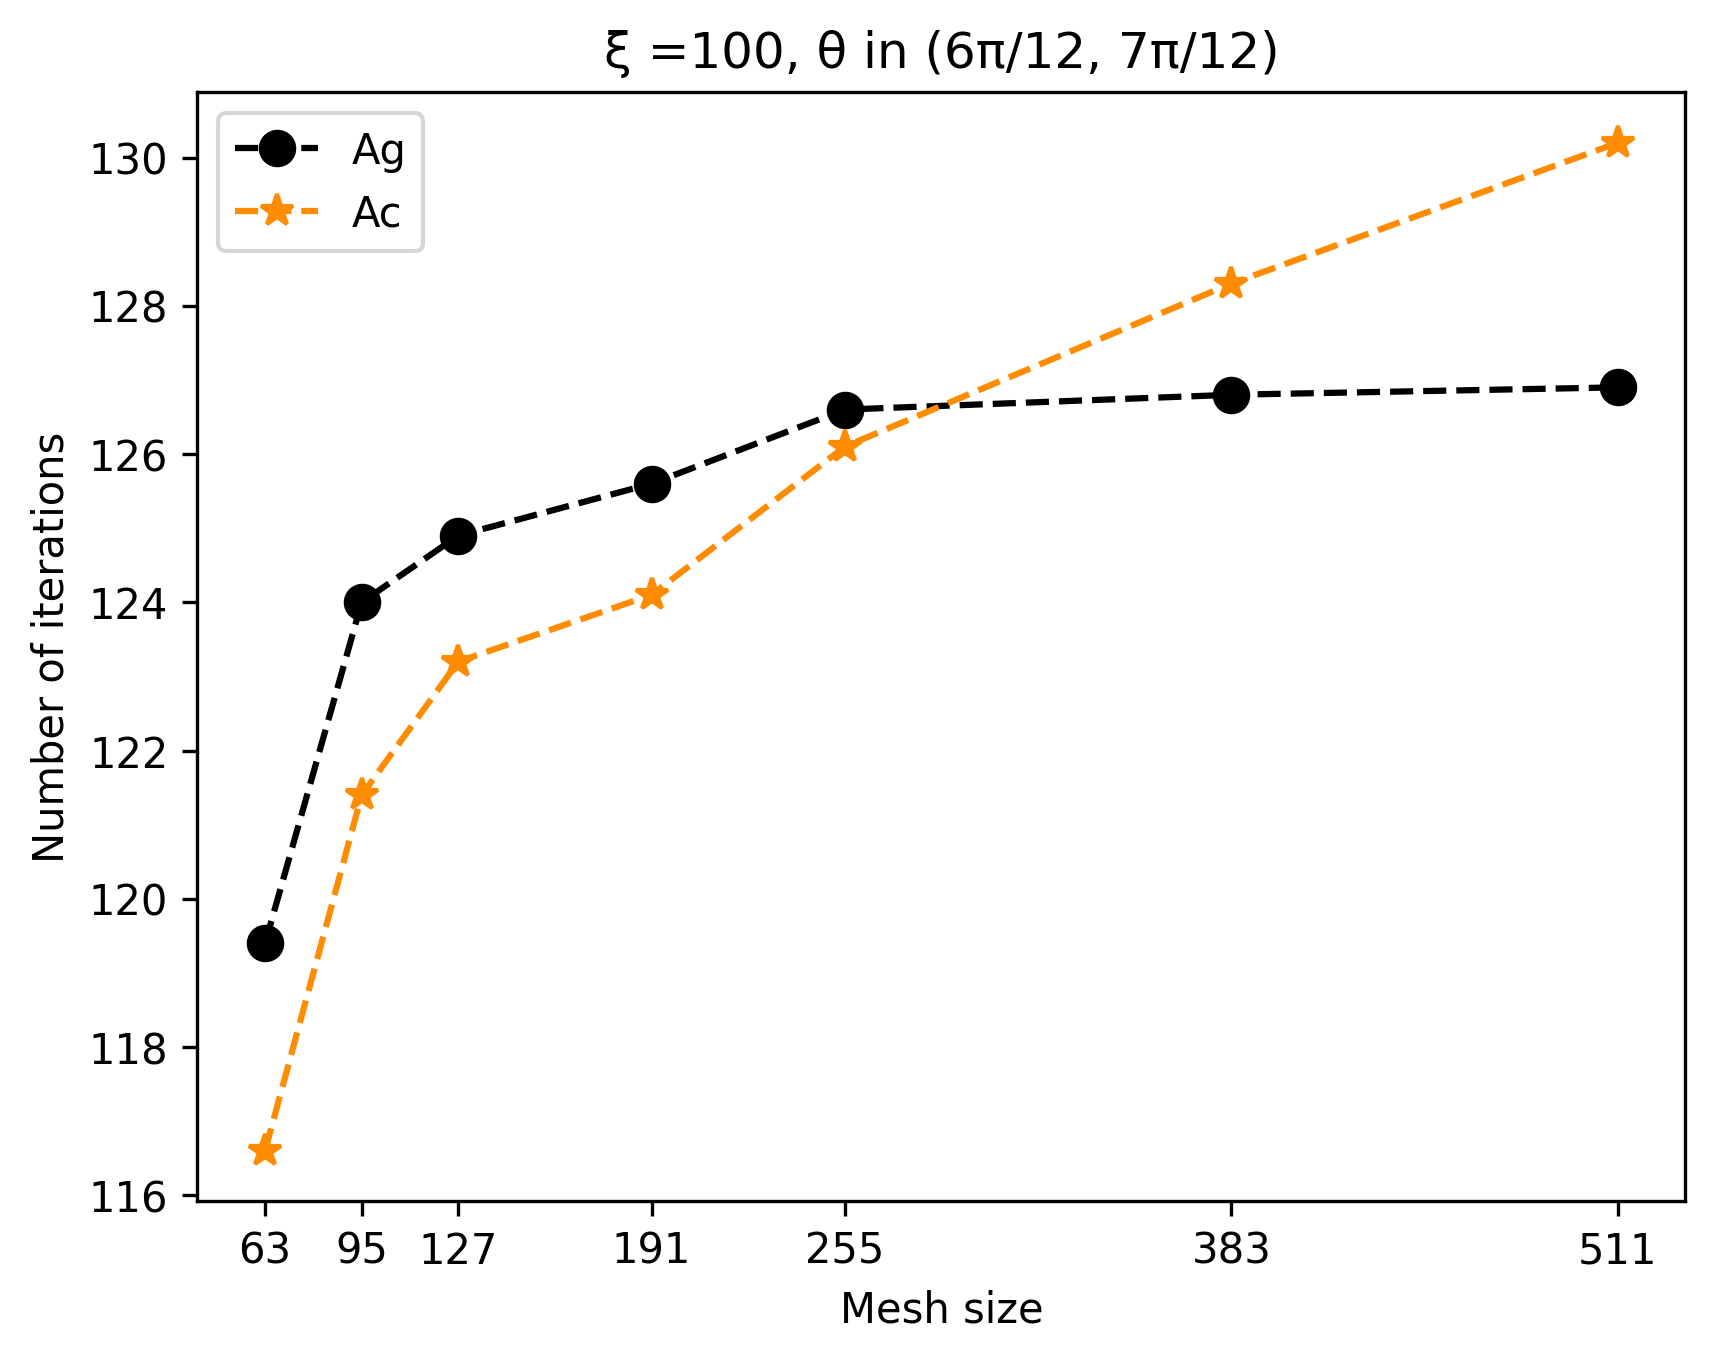

In [76]:
import matplotlib.pyplot as plt
import numpy as np

sizes = [63,95,127,191,255,383,511]
Ag = xi100[low_pi][0]
Ac = xi100[low_pi][1]
title_name = f"ξ ={int(1/list_eps[0])}, θ in ({low_pi}π/12, {high_pi}π/12)"

fig = plt.figure(dpi=300)
plt.plot(sizes,Ag, '--o',color='black', markersize=8, label='Ag',lw=1.5)
plt.plot(sizes,Ac, '--*',color='darkorange', markersize=8, label='Ac',lw=1.5)
plt.legend()
plt.xticks(sizes)
plt.xlabel("Mesh size")
plt.ylabel("Number of iterations")
plt.title(title_name)
file_name = MODEL_DIR + f"theta-{low_pi}pi\\12-{high_pi}pi\\12.png"
plt.savefig(file_name)
plt.show()